In [12]:
# interpolate averaging kernel: from OCO2 20 levels to GEOS-Chem 47 levels

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import re

In [2]:
# Name of input Netcdf file
case_names = ['Jan', 'Feb', 'Mar'] # name parts of 3 simulations

input_directory = '/geos/u73/msadiq/GEOS-Chem/analysis/python/data/'

avg_kern_name = 'interpolated_avg_kern.nc'
model_file_name = '2d_ts_' + case_names[2] + '.nc' # model output: March emitting case
oco2_file_name = '2d_OCO2_extract.nc'
output_directory = input_directory

# Name of output netCDF file
output_file = output_directory + 'interpolated_avg_kern.nc'

In [3]:
ds_satellite = xr.open_dataset(input_directory + oco2_file_name)
ds_satellite

<xarray.Dataset>
Dimensions:                (levels: 20, record: 406224)
Coordinates:
  * record                 (record) int64 0 1 2 3 ... 406221 406222 406223
  * levels                 (levels) float32 1e-04 0.05263158 ... 0.94736844 1.0
Data variables:
    xco2                   (record) float32 ...
    lat                    (record) float64 ...
    lon                    (record) float64 ...
    date                   (record) datetime64[ns] ...
    xco2_averaging_kernel  (record, levels) float32 ...
    psurf                  (record) float32 ...
    pressure               (record, levels) float32 ...
Attributes:
    comment:  flattened from 4d NetCDF file, after extracted from OCO2

In [4]:
ds_model = xr.open_dataset(input_directory + model_file_name)
ds_model
#ds['xco2_averaging_kernel'].isel(levels=19,time=0).plot()

<xarray.Dataset>
Dimensions:               (levels: 47, record: 406224)
Coordinates:
  * record                (record) int64 0 1 2 3 ... 406220 406221 406222 406223
  * levels                (levels) float64 0.9925 0.9775 ... 0.000127 2.763e-05
Data variables:
    SpeciesConc_CO2       (record, levels) float32 ...
    lat                   (record) float64 ...
    lon                   (record) float64 ...
    date                  (record) datetime64[ns] ...
    SpeciesConc_CO2oc     (record, levels) float32 ...
    SpeciesConc_CO2bf     (record, levels) float32 ...
    SpeciesConc_CO2ff     (record, levels) float32 ...
    SpeciesConc_CO2Tag1   (record, levels) float32 ...
    SpeciesConc_CO2Tag2   (record, levels) float32 ...
    SpeciesConc_CO2Tag3   (record, levels) float32 ...
    SpeciesConc_CO2Tag4   (record, levels) float32 ...
    SpeciesConc_CO2Tag5   (record, levels) float32 ...
    SpeciesConc_CO2Tag6   (record, levels) float32 ...
    SpeciesConc_CO2Tag7   (record, levels) float32 ...
    SpeciesConc_CO2Tag8   (record, levels) float32 ...
    SpeciesConc_CO2Tag9   (record, levels) float32 ...
    SpeciesConc_CO2Tag10  (record, levels) float32 ...
    SpeciesConc_CO2Tag11  (record, levels) float32 ...
    SpeciesConc_CO2Tag12  (record, levels) float32 ...
    SpeciesConc_CO2Tag13  (record, levels) float32 ...
    SpeciesConc_CO2Tag14  (record, levels) float32 ...
    SpeciesConc_CO2Tag15  (record, levels) float32 ...
    SpeciesConc_CO2Tag16  (record, levels) float32 ...
    SpeciesConc_CO2Tag17  (record, levels) float32 ...
    SpeciesConc_CO2Tag18  (record, levels) float32 ...
    SpeciesConc_CO2Tag19  (record, levels) float32 ...
    SpeciesConc_CO2Tag20  (record, levels) float32 ...
    SpeciesConc_CO2Tag21  (record, levels) float32 ...
    SpeciesConc_CO2Tag22  (record, levels) float32 ...
    PEDGE_S_PSURF         (record, levels) float32 ...
Attributes:
    comment:  [CO2] unit: ppbv

In [10]:
ds_kernel = xr.open_dataset(input_directory + avg_kern_name)
avg_kernel = ds_kernel['avg_kern']
ds_kernel

<xarray.Dataset>
Dimensions:   (levels: 47, record: 406224)
Coordinates:
  * record    (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
  * levels    (levels) float64 0.9925 0.9775 0.9624 ... 0.000127 2.763e-05
Data variables:
    avg_kern  (record, levels) float32 ...

In [6]:
record = ds_model['record'].values
record

array([     0,      1,      2, ..., 406221, 406222, 406223])

In [7]:
varnames = list(ds_model.data_vars.keys())  # Get a list of variable names. The expression is a bit cumbersome. Just copy and paste it for now.
co2_var_names = varnames[7:29]
co2_var_names

['SpeciesConc_CO2Tag1',
 'SpeciesConc_CO2Tag2',
 'SpeciesConc_CO2Tag3',
 'SpeciesConc_CO2Tag4',
 'SpeciesConc_CO2Tag5',
 'SpeciesConc_CO2Tag6',
 'SpeciesConc_CO2Tag7',
 'SpeciesConc_CO2Tag8',
 'SpeciesConc_CO2Tag9',
 'SpeciesConc_CO2Tag10',
 'SpeciesConc_CO2Tag11',
 'SpeciesConc_CO2Tag12',
 'SpeciesConc_CO2Tag13',
 'SpeciesConc_CO2Tag14',
 'SpeciesConc_CO2Tag15',
 'SpeciesConc_CO2Tag16',
 'SpeciesConc_CO2Tag17',
 'SpeciesConc_CO2Tag18',
 'SpeciesConc_CO2Tag19',
 'SpeciesConc_CO2Tag20',
 'SpeciesConc_CO2Tag21',
 'SpeciesConc_CO2Tag22']

In [8]:
ds_satellite['pressure'][47007,19] # one record where data is available for OCO2

<xarray.DataArray 'pressure' ()>
array(1014.635, dtype=float32)
Coordinates:
    record   int64 47007
    levels   float32 1.0

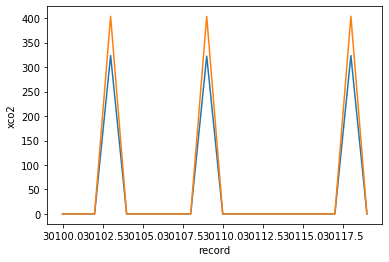

In [11]:
# testing SpeciesConc_CO2
co2_profile = ds_model['SpeciesConc_CO2']
tmp = co2_profile * avg_kernel
#ds_model['SpeciesConc_CO2'][47007,:].plot()
#tmp[47007,:].plot()
xco2_model = tmp.mean(dim = 'levels')*1e-3 # average along vertical axis, unit: ppbv -> ppm
xco2_model[30100:30120].plot()
ds_satellite['xco2'][30100:30120].plot()

In [12]:
# new dataset to store all model xco2
lat = ds_satellite['lat']
lon = ds_satellite['lon']
date = ds_satellite['date']
xco2_model = lat.to_dataset()
xco2_model['lon'] = lon
xco2_model['date'] = date
xco2_model

<xarray.Dataset>
Dimensions:  (record: 406224)
Coordinates:
  * record   (record) int64 0 1 2 3 4 5 ... 406219 406220 406221 406222 406223
Data variables:
    lat      (record) float64 ...
    lon      (record) float64 ...
    date     (record) datetime64[ns] ...

In [14]:
for icase in case_names:
    for ivar in co2_var_names:
        model_file_name = model_file_name = '2d_ts_' + icase + '.nc'  # open each simulation result
        ds_model = xr.open_dataset(input_directory + model_file_name) 
        
        co2_profile = ds_model[ivar]
        co2_times_kernel = co2_profile * avg_kernel
        xco2_model_var = co2_times_kernel.mean(dim = 'levels') * 1e-3 # average along vertical axis, unit: ppbv -> ppm
        tmp_name = icase + '_X_' + ivar
        xco2_model[tmp_name] = xco2_model_var.copy()
        print(tmp_name)
        #xco2_model_var[30100:30120].plot()

Jan_X_SpeciesConc_CO2Tag1
Jan_X_SpeciesConc_CO2Tag2
Jan_X_SpeciesConc_CO2Tag3
Jan_X_SpeciesConc_CO2Tag4
Jan_X_SpeciesConc_CO2Tag5
Jan_X_SpeciesConc_CO2Tag6
Jan_X_SpeciesConc_CO2Tag7
Jan_X_SpeciesConc_CO2Tag8
Jan_X_SpeciesConc_CO2Tag9
Jan_X_SpeciesConc_CO2Tag10
Jan_X_SpeciesConc_CO2Tag11
Jan_X_SpeciesConc_CO2Tag12
Jan_X_SpeciesConc_CO2Tag13
Jan_X_SpeciesConc_CO2Tag14
Jan_X_SpeciesConc_CO2Tag15
Jan_X_SpeciesConc_CO2Tag16
Jan_X_SpeciesConc_CO2Tag17
Jan_X_SpeciesConc_CO2Tag18
Jan_X_SpeciesConc_CO2Tag19
Jan_X_SpeciesConc_CO2Tag20
Jan_X_SpeciesConc_CO2Tag21
Jan_X_SpeciesConc_CO2Tag22
Feb_X_SpeciesConc_CO2Tag1
Feb_X_SpeciesConc_CO2Tag2
Feb_X_SpeciesConc_CO2Tag3
Feb_X_SpeciesConc_CO2Tag4
Feb_X_SpeciesConc_CO2Tag5
Feb_X_SpeciesConc_CO2Tag6
Feb_X_SpeciesConc_CO2Tag7
Feb_X_SpeciesConc_CO2Tag8
Feb_X_SpeciesConc_CO2Tag9
Feb_X_SpeciesConc_CO2Tag10
Feb_X_SpeciesConc_CO2Tag11
Feb_X_SpeciesConc_CO2Tag12
Feb_X_SpeciesConc_CO2Tag13
Feb_X_SpeciesConc_CO2Tag14
Feb_X_SpeciesConc_CO2Tag15
Feb_X_SpeciesConc_C

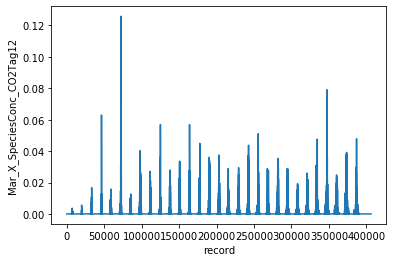

In [18]:
xco2_model['Mar_X_SpeciesConc_CO2Tag12'].plot()